# Set up

The following package will download the TSV files from IMDB website and store the data into a SQLite database (requires 10GB of disk space)


In [1]:
!pip install imdb-sqlite

In [2]:
%%time
!imdb-sqlite

2022-01-24 09:59:00,919 DB already exists: (imdb.db). Refusing to modify. Exiting
CPU times: user 8.98 ms, sys: 4.17 ms, total: 13.1 ms
Wall time: 230 ms


In [3]:
# Need this package for hadling country ISO codes
!pip install pycountry

In [4]:
# Imports
from matplotlib import cm  # Color maps
from sklearn.feature_extraction.text import CountVectorizer  # Convert a collection of text documents to a matrix of token counts
import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


In [5]:
# Some tweaks

warnings.filterwarnings('ignore')  # Don't show warnings
sns.set_theme(style='whitegrid')

# Database structure analysis

In [6]:
# Connect to databse
conn = sqlite3.connect('imdb.db')

In [7]:
# Retrieve tables' names
tables = pd.read_sql_query('SELECT name AS "Table_name" FROM sqlite_master WHERE type="table"', conn)
tables.head()

,Table_name
0,people
1,titles
2,akas
3,crew
4,episodes


In [8]:
# Retrieve each table's schema

tables_names = tables['Table_name'].values.tolist()

for table_name in tables_names:
    schema = pd.read_sql_query(f'PRAGMA TABLE_INFO({table_name})', conn)
    print(f'Schema for table {table_name}:')
    display(schema)
    print(f'{50 * "_"}\n\n')

Schema for table people:


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


__________________________________________________


Schema for table titles:


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


__________________________________________________


Schema for table akas:


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


__________________________________________________


Schema for table crew:


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


__________________________________________________


Schema for table episodes:


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


__________________________________________________


Schema for table ratings:


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


__________________________________________________




# 1. The most common content categories in IMDB

In [9]:
# Retrieve the data
query = 'SELECT type, COUNT(*) AS abs_frequency FROM titles GROUP BY type ORDER BY abs_frequency DESC'
dataframe = pd.read_sql_query(query, conn)
display(dataframe)

,type,abs_frequency
0,tvEpisode,6404250
1,short,849453
2,movie,598170
3,video,256280
4,tvSeries,218814
5,tvMovie,134354
6,tvMiniSeries,41405
7,tvSpecial,35501
8,videoGame,30088
9,tvShort,10427


In [10]:
# Remove tvEpisode type
dataframe = dataframe.drop(labels=0, axis=0)

In [11]:
# Add the relative_frequency
sum_abs_freq = dataframe['abs_frequency'].sum()
dataframe['rel_frequency'] = (dataframe['abs_frequency'] / sum_abs_freq) * 100
display(dataframe)

,type,abs_frequency,rel_frequency
1,short,849453,39.064398
2,movie,598170,27.508469
3,video,256280,11.785730
4,tvSeries,218814,10.062755
5,tvMovie,134354,6.178633
6,tvMiniSeries,41405,1.904121
7,tvSpecial,35501,1.632610
8,videoGame,30088,1.383678
9,tvShort,10427,0.479514
10,tvPilot,2,0.000092


Now let's create a graph with 5 categories:

4 categories with the the biggest amount of titles.

1 category with the others


In [12]:
# Others category
others = {}
others['type'] = 'others'
others['abs_frequency'] = dataframe.iloc[4:]['abs_frequency'].sum()
others['rel_frequency'] = dataframe.iloc[4:]['rel_frequency'].sum()
others

{'type': 'others',
 'abs_frequency': 251777,
 'rel_frequency': 11.578647722182724}

In [13]:
# The common title categories dataframe
dataframe = dataframe.head(4)
dataframe = dataframe.append(others, ignore_index=True)  # Append others category
dataframe = dataframe.sort_values(by='rel_frequency', ascending=False)
dataframe

,type,abs_frequency,rel_frequency
0,short,849453,39.064398
1,movie,598170,27.508469
2,video,256280,11.785730
4,others,251777,11.578648
3,tvSeries,218814,10.062755


In [14]:
# Labels
labels = []

for i in dataframe.index:
    cont_type = dataframe.loc[i]["type"]
    cont_type = re.sub(r"(\w)([A-Z])", r"\1 \2", cont_type) # Add space before capital letters
    cont_type = cont_type[0].upper() + cont_type[1:] # Uppercase the first letter without changing the rest

    rel_freq = round(dataframe.loc[i]["rel_frequency"], 2)

    labels.append(f'{cont_type} {rel_freq}%')

labels

['Short 39.06%',
 'Movie 27.51%',
 'Video 11.79%',
 'Others 11.58%',
 'Tv Series 10.06%']

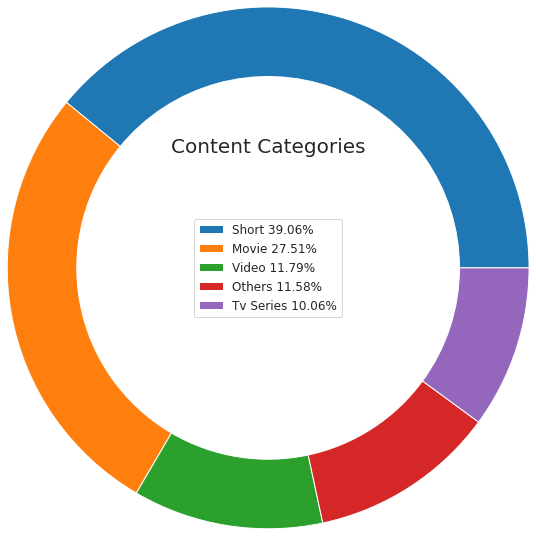

In [15]:
# Plot

# Set color map
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
cs = cm.tab10(range(100))

plt.pie(dataframe['rel_frequency'], colors=cs, labeldistance=1, radius=3, wedgeprops=dict(width=0.8))
plt.legend(labels=labels, loc='center', fontsize=12)
plt.title(label='Content Categories', loc='center', fontdict={'fontsize': 20, 'fontweight': 20})
plt.show()

# 2. Percentage of movies per genre

In [16]:
# Retrieve movie genres and sort them
query = 'SELECT genres FROM titles WHERE type="movie"'
dataframe = pd.read_sql_query(query, conn)
display(dataframe)

,genres
0,\N
1,"Action,Adventure,Biography"
2,Drama
3,Drama
4,Drama
...,...
598165,Documentary
598166,Documentary
598167,Comedy
598168,\N


In [17]:
# Lowercase genres
dataframe['genres'] = dataframe['genres'].str.lower()

In [18]:
# Function for removing missing values

def rm_miss_values(df: pd.DataFrame, column: str, miss_indicator: str = '\\n') -> pd.DataFrame:
    if column != None:
        df[column].replace(miss_indicator, np.nan, inplace=True)
        cleared_df = df.dropna(subset=[column])
    else:
        df.replace(miss_indicator, np.nan, inplace=True)
        cleared_df = df.dropna()
    return cleared_df

In [19]:
# Remove missing values
genres_df = rm_miss_values(dataframe, 'genres')
display(genres_df)

,genres
1,"action,adventure,biography"
2,drama
3,drama
4,drama
5,drama
...,...
598164,drama
598165,documentary
598166,documentary
598167,comedy


#### How CountVectorizer works:

![How CountVectorizer works](https://mlwhiz.com/images/countvectorizer.png)

In [20]:
# Function that creates a dataframe with unique genres and the respectively absolute frequency

def df_uniq_genres_abs_freq(df: pd.DataFrame, column: str, abs_freq=True) -> pd.DataFrame:
    # Match words with lenght > 1 and with - or not
    pattern = '(?u)\\b\\w[\\w-]+\\b'

    # Deals with multi-categorical data
    vect = CountVectorizer(token_pattern=pattern).fit(df[column])

    # Create Document-term matrix.
    bag_genres = vect.transform(df[column])

    # Create array of unique genres
    unique_genres = vect.get_feature_names()

    if abs_freq:
        # Sum sparse matrix columns
        genres_abs_freq = bag_genres.toarray().sum(axis=0)

        # Return DataFrame with genres and absolute frequencies
        return pd.DataFrame(zip(unique_genres, genres_abs_freq), columns=['genre', 'abs_freq'])
    else:
        return pd.DataFrame(unique_genres, columns=['genre'])

In [21]:
# Create final dataframe
genres_df = df_uniq_genres_abs_freq(genres_df, column='genres')
genres_df

,genre,abs_freq
0,action,50125
1,adult,8373
2,adventure,26155
3,animation,8000
4,biography,15732
5,comedy,101597
6,crime,34241
7,documentary,110581
8,drama,214746
9,family,16540


In [22]:
# Sum of absolute frequencies
freq_total_sum = genres_df['abs_freq'].sum()
freq_total_sum

805703

In [23]:
# Sort by absolute frequency
genres_df = genres_df.sort_values(by='abs_freq', ascending=False)
genres_df

,genre,abs_freq
8,drama,214746
7,documentary,110581
5,comedy,101597
0,action,50125
20,romance,44035
25,thriller,40393
6,crime,34241
14,horror,32954
2,adventure,26155
9,family,16540


In [24]:
# Add relative frequencies to dataframe
genres_df['rel_freq'] = [(abs_freq / freq_total_sum) * 100 for abs_freq in genres_df['abs_freq']]
genres_df

,genre,abs_freq,rel_freq
8,drama,214746,26.653246
7,documentary,110581,13.724784
5,comedy,101597,12.609733
0,action,50125,6.221275
20,romance,44035,5.465413
25,thriller,40393,5.013386
6,crime,34241,4.249829
14,horror,32954,4.090093
2,adventure,26155,3.246233
9,family,16540,2.052866


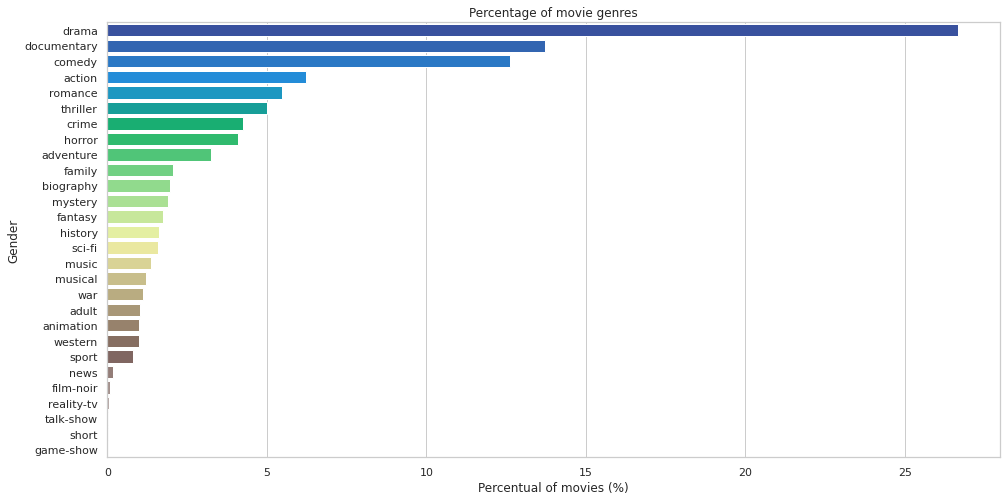

In [25]:
# Plot

plt.figure(figsize=(16, 8))
sns.barplot(x=genres_df['rel_freq'].tolist(), y=genres_df['genre'].tolist(),
            orient='h', palette='terrain')
plt.ylabel('Gender')
plt.xlabel('Percentual of movies (%)')
plt.title('Percentage of movie genres')
plt.show()


# 3. Movie ratings median per genre

In [26]:
query = 'SELECT rating, genres AS genre FROM ratings JOIN titles ON ratings.title_id = titles.title_id WHERE type = "movie"'

In [27]:
genre_df = pd.read_sql_query(query, conn)
display(genre_df)

,rating,genre
0,4.4,\N
1,6.1,"Action,Adventure,Biography"
2,5.0,Drama
3,4.5,Drama
4,3.9,Drama
...,...,...
273316,3.5,"Action,Adventure,Thriller"
273317,5.8,Thriller
273318,6.4,"Drama,History"
273319,3.8,"Adventure,History,War"


In [28]:
genre_df['genre'] = genre_df['genre'].str.lower()
display(genre_df)

,rating,genre
0,4.4,\n
1,6.1,"action,adventure,biography"
2,5.0,drama
3,4.5,drama
4,3.9,drama
...,...,...
273316,3.5,"action,adventure,thriller"
273317,5.8,thriller
273318,6.4,"drama,history"
273319,3.8,"adventure,history,war"


In [29]:
# Remove missing values
genre_df = rm_miss_values(genre_df, column='genre')
display(genre_df)

,rating,genre
1,6.1,"action,adventure,biography"
2,5.0,drama
3,4.5,drama
4,3.9,drama
5,4.7,drama
...,...,...
273316,3.5,"action,adventure,thriller"
273317,5.8,thriller
273318,6.4,"drama,history"
273319,3.8,"adventure,history,war"


In [30]:
genre_df = df_uniq_genres_abs_freq(genre_df, column='genre')
genre_df

,genre,abs_freq
0,action,28315
1,adult,4224
2,adventure,17152
3,animation,4799
4,biography,8232
5,comedy,67741
6,crime,23317
7,documentary,40379
8,drama,121092
9,family,10608


In [31]:
# Compute the rating median for each gender
def genre_rating_median(genres: list, conn: sqlite3.Connection) -> dict:
    genre_ratings = {}

    for genre in genres:
        query = f'SELECT rating FROM ratings JOIN titles ON ratings.title_id = titles.title_id WHERE genres LIKE "%{genre}%" AND type = "movie"'
        result = pd.read_sql_query(query, conn)
        genre_ratings[genre] = np.median(result['rating'])

    return genre_ratings

In [32]:
genre_ratings = genre_rating_median(genre_df['genre'], conn)
genre_ratings

{'action': 5.8,
 'adult': 5.9,
 'adventure': 6.0,
 'animation': 6.4,
 'biography': 7.0,
 'comedy': 6.0,
 'crime': 6.1,
 'documentary': 7.3,
 'drama': 6.3,
 'family': 6.3,
 'fantasy': 6.1,
 'film-noir': 6.6,
 'game-show': 6.800000000000001,
 'history': 6.9,
 'horror': 5.0,
 'music': 6.6,
 'musical': 6.2,
 'mystery': 6.0,
 'news': 7.3,
 'reality-tv': 6.1,
 'romance': 6.2,
 'sci-fi': 5.4,
 'short': 7.2,
 'sport': 6.7,
 'talk-show': 6.9,
 'thriller': 5.6,
 'war': 6.6,
 'western': 6.0}

In [33]:
# Game Show, Talk Show, Reality TV and News aren't movie genres, so lets remove them
def rm_non_movie_genres(df: pd.DataFrame, column: str = 'genre', genres_to_rm: list = ['game-show', 'talk-show', 'news', 'reality-tv']) -> pd.DataFrame:
    for genre in genres_to_rm:
        df = df[df[column] != genre]

    return df

In [34]:
# Create column rating and sort them

genre_df['rating'] = genre_ratings.values()
genre_df = genre_df.sort_values(by='rating', ascending=False)
genre_df

,genre,abs_freq,rating
7,documentary,40379,7.3
18,news,652,7.3
22,short,23,7.2
4,biography,8232,7.0
13,history,7513,6.9
24,talk-show,8,6.9
12,game-show,2,6.8
23,sport,3224,6.7
11,film-noir,762,6.6
15,music,6368,6.6


In [35]:
# Remobe unwanted genres
genre_df = rm_non_movie_genres(genre_df)
display(genre_df)

,genre,abs_freq,rating
7,documentary,40379,7.3
22,short,23,7.2
4,biography,8232,7.0
13,history,7513,6.9
23,sport,3224,6.7
11,film-noir,762,6.6
15,music,6368,6.6
26,war,5874,6.6
3,animation,4799,6.4
8,drama,121092,6.3


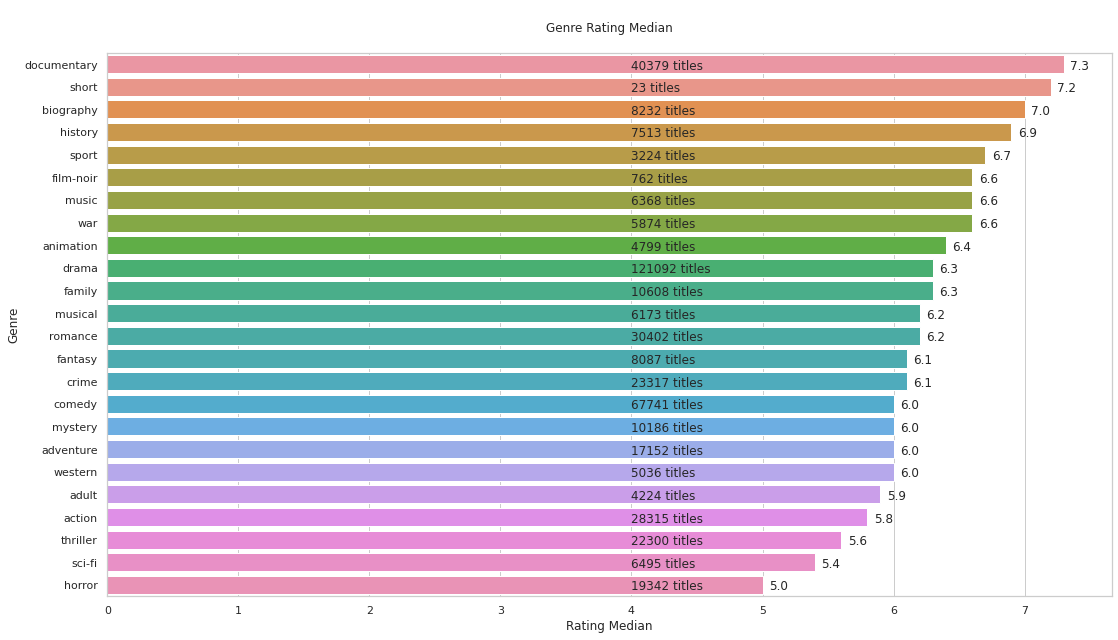

In [36]:
# Plot

plt.figure(figsize=(18, 10))
sns.barplot(x=genre_df['rating'], y=genre_df['genre'], orient='h')

# Plot Text
for i in range(len(genre_df.index)):
    plt.text(x=4, y=i + .22,
             s=f'{genre_df["abs_freq"][genre_df.index[i]]} titles')

    rating = genre_df['rating'][genre_df.index[i]]
    plt.text(x=rating + .05, y=i + .22, s=rating)

plt.xlabel('Rating Median')
plt.ylabel('Genre')
plt.title('\nGenre Rating Median\n')
plt.show()

# 4. Median of movie ratings by premiered year

In [37]:
query = 'SELECT rating, premiered FROM ratings JOIN titles ON ratings.title_id = titles.title_id WHERE type = "movie" ORDER BY premiered'

In [38]:
df = pd.read_sql_query(query, conn)
display(df)

,rating,premiered
0,5.6,NaN
1,7.5,NaN
2,7.4,NaN
3,4.8,NaN
4,5.7,NaN
...,...,...
273316,5.4,2022.0
273317,8.0,2022.0
273318,8.0,2022.0
273319,1.7,2022.0


In [39]:
# Clear empty values

df.dropna(axis=0, inplace=True)
df

,rating,premiered
27,6.2,1896.0
28,4.5,1897.0
29,3.9,1899.0
30,3.7,1899.0
31,6.0,1900.0
...,...,...
273316,5.4,2022.0
273317,8.0,2022.0
273318,8.0,2022.0
273319,1.7,2022.0


In [40]:
# Computes the median

ratings = {}
for i in set(df['premiered']):
    ratings_df = df[df['premiered'] == i]['rating']
    ratings[i] = np.median(ratings_df)

ratings

{1896.0: 6.2,
 1897.0: 4.5,
 1899.0: 3.8,
 1900.0: 5.85,
 1901.0: 4.6,
 1902.0: 3.5,
 1903.0: 5.6,
 1904.0: 5.4,
 1905.0: 4.4,
 1906.0: 3.7,
 1907.0: 4.5,
 1908.0: 5.3,
 1909.0: 4.8,
 1910.0: 4.8,
 1911.0: 4.6,
 1912.0: 5.6,
 1913.0: 5.7,
 1914.0: 6.0,
 1915.0: 6.2,
 1916.0: 6.2,
 1917.0: 6.2,
 1918.0: 6.0,
 1919.0: 6.1,
 1920.0: 5.7,
 1921.0: 6.2,
 1922.0: 6.2,
 1923.0: 6.3,
 1924.0: 6.4,
 1925.0: 6.3,
 1926.0: 6.4,
 1927.0: 6.5,
 1928.0: 6.6,
 1929.0: 6.4,
 1930.0: 6.05,
 1931.0: 6.0,
 1932.0: 6.2,
 1933.0: 6.3,
 1934.0: 6.2,
 1935.0: 6.2,
 1936.0: 6.2,
 1937.0: 6.2,
 1938.0: 6.2,
 1939.0: 6.3,
 1940.0: 6.3,
 1941.0: 6.3,
 1942.0: 6.2,
 1943.0: 6.3,
 1944.0: 6.2,
 1945.0: 6.2,
 1946.0: 6.4,
 1947.0: 6.4,
 1948.0: 6.4,
 1949.0: 6.4,
 1950.0: 6.3,
 1951.0: 6.3,
 1952.0: 6.3,
 1953.0: 6.2,
 1954.0: 6.2,
 1955.0: 6.3,
 1956.0: 6.2,
 1957.0: 6.3,
 1958.0: 6.3,
 1959.0: 6.3,
 1960.0: 6.4,
 1961.0: 6.3,
 1962.0: 6.3,
 1963.0: 6.3,
 1964.0: 6.3,
 1965.0: 6.2,
 1966.0: 6.2,
 1967.0: 6.2,
 196

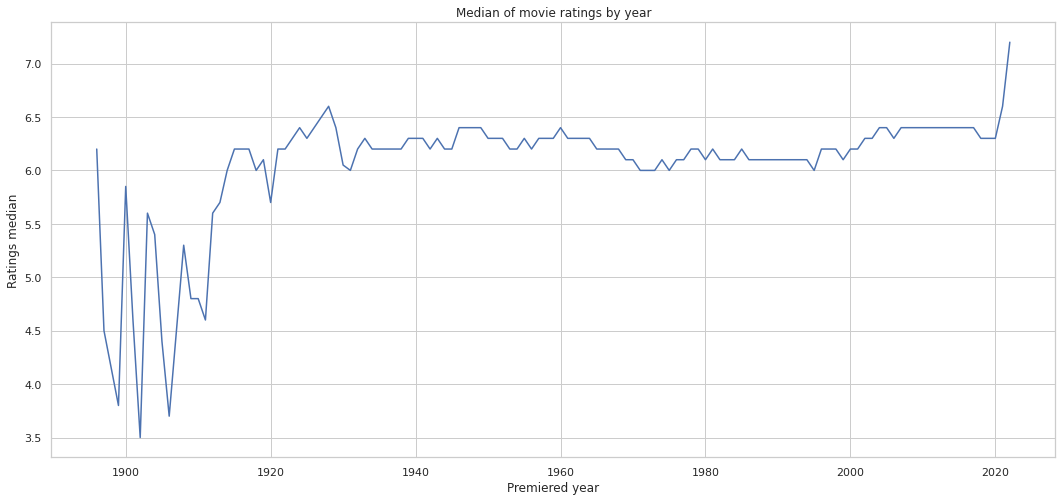

In [41]:
# Plot

plt.figure(figsize=(18, 8))
sns.lineplot(x=ratings.keys(), y=ratings.values())
plt.title('Median of movie ratings by year')
plt.xlabel('Premiered year')
plt.ylabel('Ratings median')
plt.show()

# 5. Number of titles premiered each year by genre

In [42]:
query = 'SELECT genres FROM titles WHERE type = "movie"'

In [43]:
df = pd.read_sql_query(query, conn)
df

,genres
0,\N
1,"Action,Adventure,Biography"
2,Drama
3,Drama
4,Drama
...,...
598165,Documentary
598166,Documentary
598167,Comedy
598168,\N


In [44]:
# Clear data

# Lowercase genres
df['genres'] = df['genres'].str.lower()

df = rm_miss_values(df, column=None)
df

,genres
1,"action,adventure,biography"
2,drama
3,drama
4,drama
5,drama
...,...
598164,drama
598165,documentary
598166,documentary
598167,comedy


In [45]:
# Compute unique genres from df

genres_df = df_uniq_genres_abs_freq(df, 'genres', abs_freq=False)
genres_df

,genre
0,action
1,adult
2,adventure
3,animation
4,biography
5,comedy
6,crime
7,documentary
8,drama
9,family


In [46]:
# Game Show, Talk Show, Reality TV and News aren't movie genres, so lets remove them

for genre in ['game-show', 'talk-show', 'news', 'reality-tv']:
    genres_df = genres_df[genres_df.genre != genre]

display(genres_df)

,genre
0,action
1,adult
2,adventure
3,animation
4,biography
5,comedy
6,crime
7,documentary
8,drama
9,family


In [47]:
# Top 5 most common genres

genre_top5 = {}

for genre in genres_df['genre']:
    query = f'SELECT COUNT(*) AS abs_freq FROM titles WHERE genres LIKE "%{genre}%" AND type = "movie" AND premiered <= 2022'
    genre_top5[genre] = pd.read_sql_query(query, conn).iloc[0]['abs_freq']

# Sort and return top 5
genre_top5 = dict(sorted(genre_top5.items(), key=lambda item: item[1], reverse=True)[:5])
genre_top5

{'drama': 189793,
 'documentary': 104134,
 'comedy': 90303,
 'action': 41058,
 'romance': 40735}

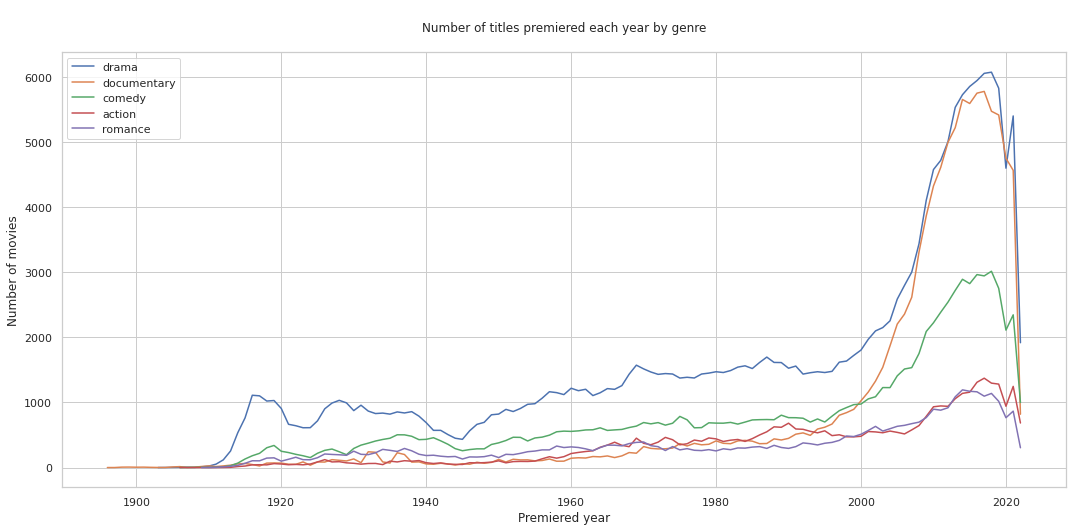

In [48]:
# Plot
plt.figure(figsize=(18,8))

# Retrive premiered movies by genre and year
for genre in genre_top5:
    query = f'SELECT premiered, COUNT(*) AS abs_frequency FROM titles WHERE genres LIKE "%{genre}%" AND premiered NOT NULL AND premiered <= 2022 AND type = "movie" GROUP BY premiered'
    genres_df = pd.read_sql_query(query, conn)
    sns.lineplot(x=genres_df['premiered'], y=genres_df['abs_frequency'])


plt.title("\nNumber of titles premiered each year by genre\n")
plt.ylabel("Number of movies")
plt.xlabel("Premiered year")
plt.legend(labels=genre_top5)
plt.show()

# 6. Average runtime by genre

In [49]:
# Retrive unique genres
query = 'SELECT genres FROM titles WHERE type = "movie" AND premiered <= 2022'
df = pd.read_sql_query(query, conn)

df = df_uniq_genres_abs_freq(df, 'genres', abs_freq=False)
df

,genre
0,action
1,adult
2,adventure
3,animation
4,biography
5,comedy
6,crime
7,documentary
8,drama
9,family


In [50]:
# Compute average runtime
genre_rtm_median = []
for genre in df['genre']:
    query = f'SELECT runtime_minutes AS runtime FROM titles WHERE type = "movie" AND premiered <= 2022 AND runtime NOT NULL AND genres LIKE "%{genre}%"'
    genre_rtm = pd.read_sql_query(query, conn)
    genre_rtm_median.append(np.median(genre_rtm['runtime']))

genre_rtm_median

[94.0,
 77.0,
 90.0,
 81.0,
 87.0,
 91.0,
 92.0,
 74.0,
 93.0,
 89.0,
 90.0,
 83.0,
 55.0,
 90.0,
 88.0,
 90.0,
 93.0,
 91.0,
 74.0,
 90.0,
 95.0,
 90.0,
 21.5,
 90.0,
 74.0,
 92.0,
 93.0,
 72.0]

In [51]:
# Final df with runtime medians and genres
rtm_median = pd.DataFrame(data=zip(df['genre'], genre_rtm_median), columns=['genre', 'runtime_median'])
rtm_median

,genre,runtime_median
0,action,94.0
1,adult,77.0
2,adventure,90.0
3,animation,81.0
4,biography,87.0
5,comedy,91.0
6,crime,92.0
7,documentary,74.0
8,drama,93.0
9,family,89.0


In [52]:
# Remove unwanted genres
rtm_median = rm_non_movie_genres(rtm_median, column='genre')
rtm_median

,genre,runtime_median
0,action,94.0
1,adult,77.0
2,adventure,90.0
3,animation,81.0
4,biography,87.0
5,comedy,91.0
6,crime,92.0
7,documentary,74.0
8,drama,93.0
9,family,89.0


In [53]:
# Sort df
rtm_median = rtm_median.sort_values(by='runtime_median', ascending=False)
rtm_median

,genre,runtime_median
20,romance,95.0
0,action,94.0
26,war,93.0
8,drama,93.0
16,musical,93.0
25,thriller,92.0
6,crime,92.0
5,comedy,91.0
17,mystery,91.0
15,music,90.0


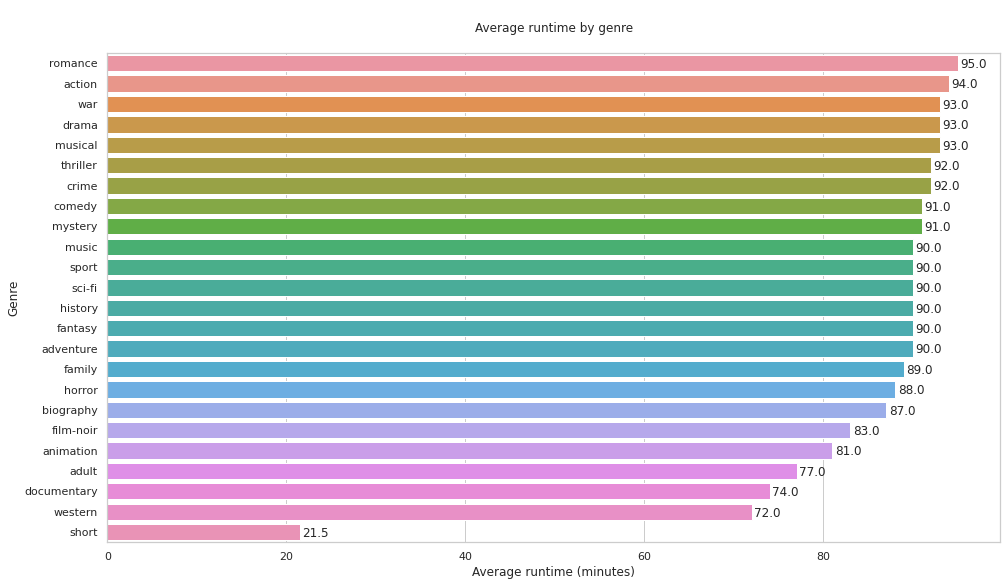

In [54]:
# Plot

plt.figure(figsize=(16,9))

# Barplot
sns.barplot(x=rtm_median['runtime_median'], y=rtm_median['genre'], orient='h')

# Median text
for i in range(len(rtm_median['genre'])):
    median = rtm_median['runtime_median'][rtm_median.index[i]]
    plt.text(x=median + .3, y=i + .23, s=median)

plt.title('\nAverage runtime by genre\n')
plt.ylabel('Genre')
plt.xlabel('Average runtime (minutes)')

plt.show()

# 7. Number of movies by country

In [55]:
query = '''SELECT region, COUNT(*) as abs_freq
	FROM akas 
		JOIN titles ON akas.title_id = titles.title_id 
	WHERE region NOT NULL 
		AND titles.type = "movie" 
		AND titles.premiered <= 2022
		AND titles.genres NOT LIKE "%game-show%" OR "%talk-show%" OR "%news%" OR "%reality-tv%"
	GROUP BY region
	ORDER BY abs_freq DESC
    LIMIT 20'''

In [56]:
df = pd.read_sql_query(query, conn)
df

,region,abs_freq
0,US,253554
1,GB,145487
2,JP,89623
3,XWW,87169
4,FR,81969
5,IN,74629
6,CA,71373
7,DE,67900
8,IT,63789
9,BR,63604


In [57]:
# Get country name by country code
countries = []

for code in df['region'].tolist():

    try:
        countries.append(pycountry.countries.get(alpha_2=code).name)
    except AttributeError:
        try:
            countries.append(pycountry.countries.get(alpha_3=code).name)
        except:
            # Cannot retrieve country name, so remove the country's data from df
            df = df[df['region'] != code]
            continue

countries

['United States',
 'United Kingdom',
 'Japan',
 'France',
 'India',
 'Canada',
 'Germany',
 'Italy',
 'Brazil',
 'Spain',
 'Greece',
 'Poland',
 'Russian Federation',
 'Hungary',
 'Finland',
 'Portugal',
 'Sweden',
 'Mexico',
 'Australia']

In [58]:
#  Final DataFrame
df = pd.DataFrame(data=zip(countries, df['abs_freq']), columns=['country', 'movies_count'])

In [59]:
df

,country,movies_count
0,United States,253554
1,United Kingdom,145487
2,Japan,89623
3,France,81969
4,India,74629
5,Canada,71373
6,Germany,67900
7,Italy,63789
8,Brazil,63604
9,Spain,63391


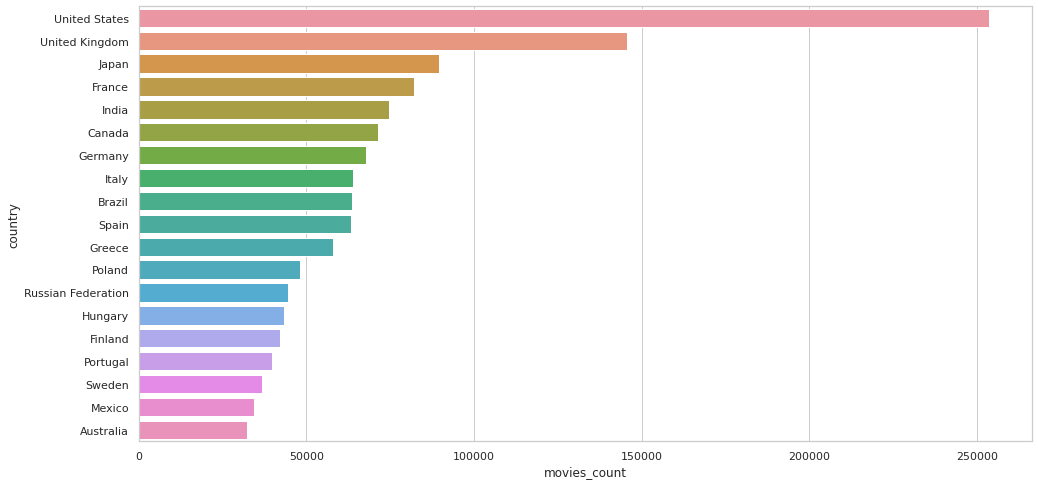

In [60]:
# Plot

plt.figure(figsize=(16,8))

sns.barplot(x=df['movies_count'], y=df['country'], orient='h')

plt.show()